# Assignment 2:

In this assignment, you are going to solve three problems: 

1. Improving Nearest Neighbors Retrieval Speed (8 points)
2. Gaussian Naive Bayes (4 points)
3. PCA (3 points)

## 1. Improving Nearest Neighbors Retrieval Speed (8 points)

You are given a dataset of coordinates and information about places around the globe. Explore the dataset. You will be mostly working with 2d vectors which represent longitude and latitude.

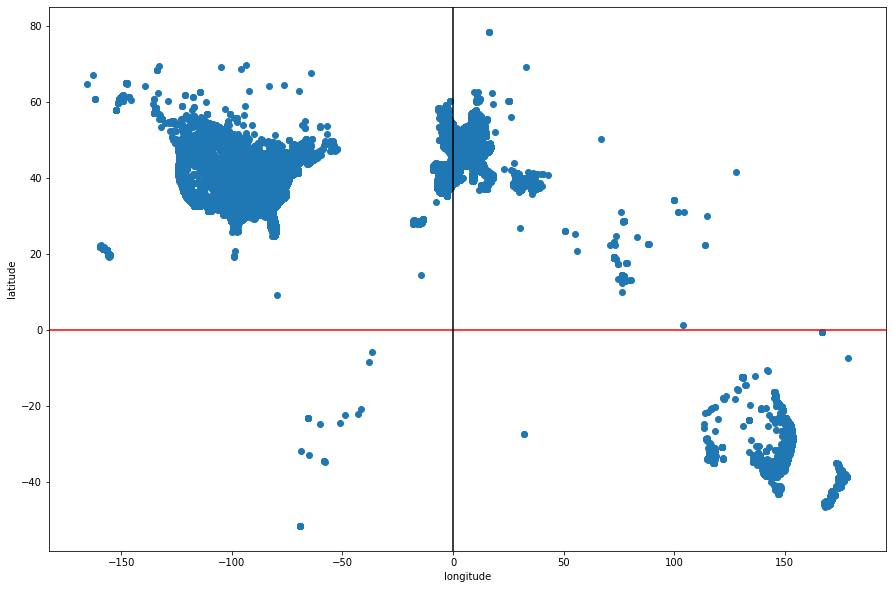

In [38]:
import matplotlib.pyplot as plt
import pickle


with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)
    
X = [v[0][0] for v in dataset]
Y = [v[0][1] for v in dataset]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

### 1.1 Simple NN Search

Implement the simplest form of NN search (exhaustive search).
Your function should: 
1. Calculate the distance between the test point and each dataset point using euclidean distance.
2. Sort the dataset according to calculated distance in ascending order.
3. Return the top K points from the sorted dataset.

You need to implement this from scratch. Don't use library solutions. 
It is okay to use library function for eucliden distance.

In [39]:
from math import sqrt

# imlementing Euclidian distance function which takes 
# two points as arguments

def distance(v, u):
    x1, y1 = v[0], v[1]
    x2, y2 = u[0], u[1]
    return sqrt((x2 - x1)**2 + ((y2 - y1)**2))

def simple_nns(v, data, k):
    """
    param: v: test point
    param: data: dataset
    param: k: number of nearest neighbors to retrive
    return: list of nearest points from the dataset
    """
    
    # initializing the distance vector and filling it with distances to the test point
    # and corresponding indeces of the 2nd point
    
    dist = []
    for i in range(len(dataset)):
        dist.append([distance(v, dataset[i][0]), i])
        
    # sorting it out with respect to distance so later we can take top-k of them
        
    dist.sort(key=lambda x: x[0])
    
    # obviously, the closets point to a test point is the test point itself
    # so we might want to delete it 
    
    del dist[0]
    
    # initializing the answer array and filling it out with k closets points
    # using index that we appended to distance array along with  Euclidian distance
    
    ans = []
    for i in range(k):
        ans.append(dataset[dist[i][1]])
    
    return ans

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

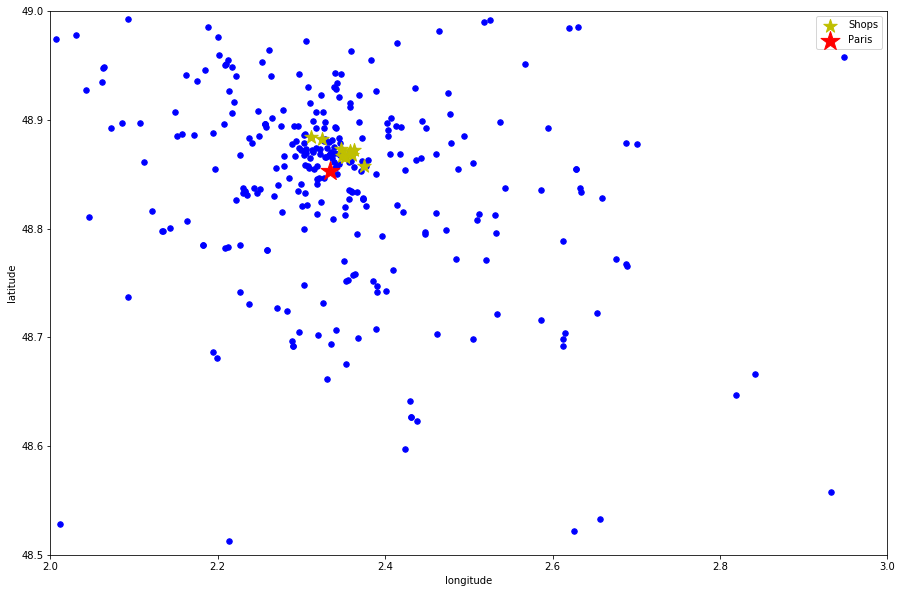

In [40]:
paris = [2.334083, 48.853260]

# obtaining 100 closest points to Paris 

paris_nn = simple_nns(paris, dataset, 100)

# creating a list of shops and going through closets point
# appending only those who have "Shop" in their description

nn_shops = []
for point in paris_nn:
    if "Shop" in point[1]:
        nn_shops.append(point)
        
# getting coordinates to plot

x_found = [v[0][0] for v in nn_shops]
y_found = [v[0][1] for v in nn_shops]

# plotting the results of simple knn

plt.figure(figsize=(15, 10))
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(X, Y, marker = 'o', color = 'b', s = 30)
plt.scatter(x_found, y_found, marker = '*', color = 'y', s = 200, label='Shops')
plt.scatter(paris[0], paris[1], marker = '*', color = 'r', s = 400, label='Paris')
plt.legend()
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

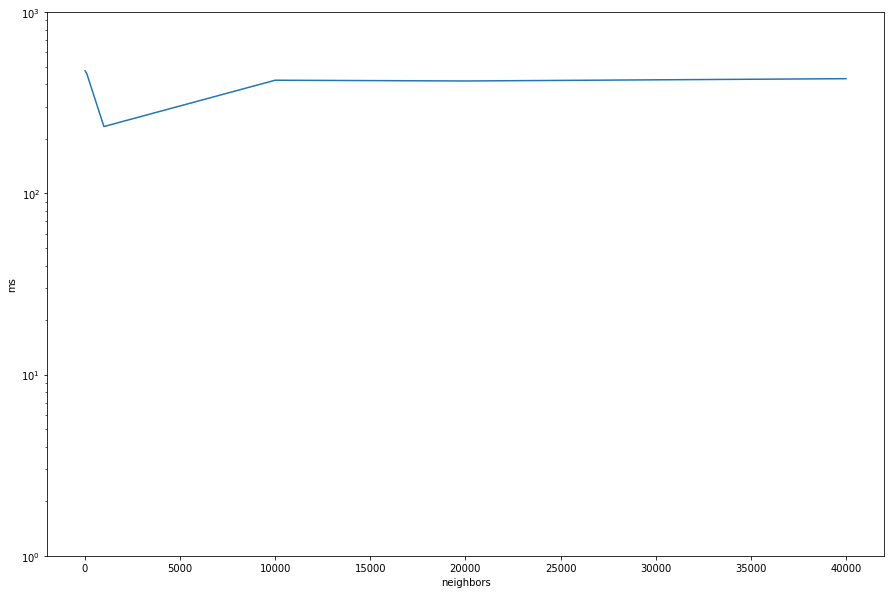

In [41]:
import time
import random

nns = [10, 100, 1000, 10000, 20000, 40000]

# creating list to store retrieval times
# and going thrugh all amounts of nearest neighbors 
# measuring the time it takes to complete the algorithm

times_simple = []
for k in nns:
    
    # selecting a random point from a dataset
    
    random_point = random.choice(dataset)[0]
    
    # starting to measure the time and calling the knn function
    
    start = time.time()
    result = simple_nns(random_point, dataset, k)
    
    # as algorithm as done now, we can stop the timer
    # and multiply obtained seconds by 1000 to get milliseconds
    # and add it to the list of results
    
    end = time.time()
    times_simple.append((end - start) * 1000)

# ploting the results the results

plt.figure(figsize=(15, 10))
plt.xlabel('neighbors')
plt.ylabel('ms')
plt.yscale('log', basey=10)
plt.ylim(1, 10**3)
plt.plot(nns, times_simple)
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: </span> times obtained using different amount of neighbors tend to lie in the interval 300-450 ms. Time is **nor increasing nor decreasing** with changing the neighbors amount, and it can be explained as follows: simple implementation of KNN goes through **all** dataset **not depending** on k parameter, and after that returns slice of created temp array. Hence, overall procedure will take approximately the **same** amount of time each time. The **complexity** of such approach may be expressed as $O(N^2)$ where $N$ is the amount of entries in the dataset, and it happens so because $O(N^2)$ is the exact complexity of sorting the array of point after evaluating distances

### 1.2 Improving NNS

Choose any method you like to speed up NN search, understand it thoroughly and learn how to apply it. Explain the way it works in few sentences and in your own words.

<span style="color:blue"> Your answer: </span> one way to speed up the simple knn is to organize the initial data into some smart data structure which will allow us to go through only a part of the dataset to determine the nearest neighbors. One of such structures is **K-Dimensional Tree (KDTree)** which is based on space partitioning, and here is how it works:
1. It picks random dimension
2. Finds the median among data and does a **split**
3. Repeats first 2 steps until a certain point 

A simple **query** to such a data structure will look like this:
1. Find the **region** containing the data point
2. **Compare** it to all points in the region
3. If more neighbors are needed then go to **nearest** region

Apply the chosen method on the geographic dataset. Similarly to the above, find the nearest neighbors and plot retrieval times.

In [42]:
from sklearn.neighbors import KDTree
import numpy as np

# preparing the initial data to be fed into the KDTree
# only coordinates need to be fed so descriptions need to be removed

data_for_tree = []
for point in dataset:
    data_for_tree.append(point[0])
    
# feeding the data to the 2-dimensional tree with a region size of 50
    
tree = KDTree(np.asarray(data_for_tree), leaf_size=50)

Find the first 100 nearest neighbors of Paris. However, we are only interested in shops. Filter out everything that doesn't contain 'Shop' substring in the description and plot the remaining points.

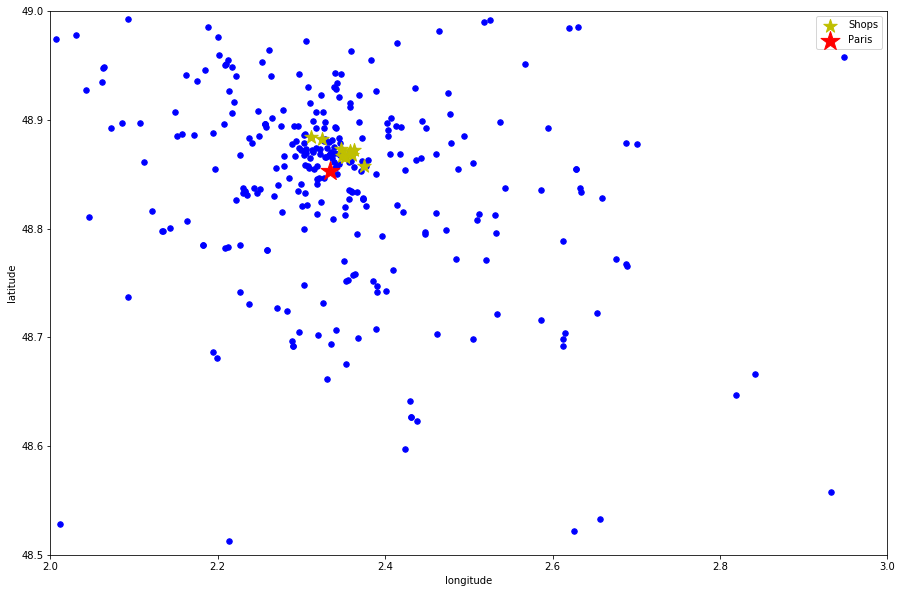

In [43]:
paris = [2.334083, 48.853260]

# making a query to KDTree with k = 100
# and obtaining list of indeces of nearest neighbors
# and corresponding distances

dist, ind = tree.query(np.asarray(paris).reshape(1,-1), k=100) 

# going through resulting points
# and leaving only those tho have "Shop"
# in their description

paris_nn = []
for index in ind[0]:
    if "Shop" in dataset[index][1]:
        paris_nn.append(dataset[index][0])

# getting coordinates to plot

x_found = [v[0] for v in paris_nn]
y_found = [v[1] for v in paris_nn]

# plotting the results

plt.figure(figsize=(15, 10))
plt.ylim(48.5, 49)
plt.xlim(2,3)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.scatter(X, Y, marker = 'o', color = 'b', s = 30)
plt.scatter(x_found, y_found, marker = '*', color = 'y', s = 200, label='Shops')
plt.scatter(paris[0], paris[1], marker = '*', color = 'r', s = 400, label='Paris')
plt.legend()
plt.show()

Measure retrieval time of `simple_nns` for every given number of nearest neighbors. Every time select some random point from the dataset. Plot the results.

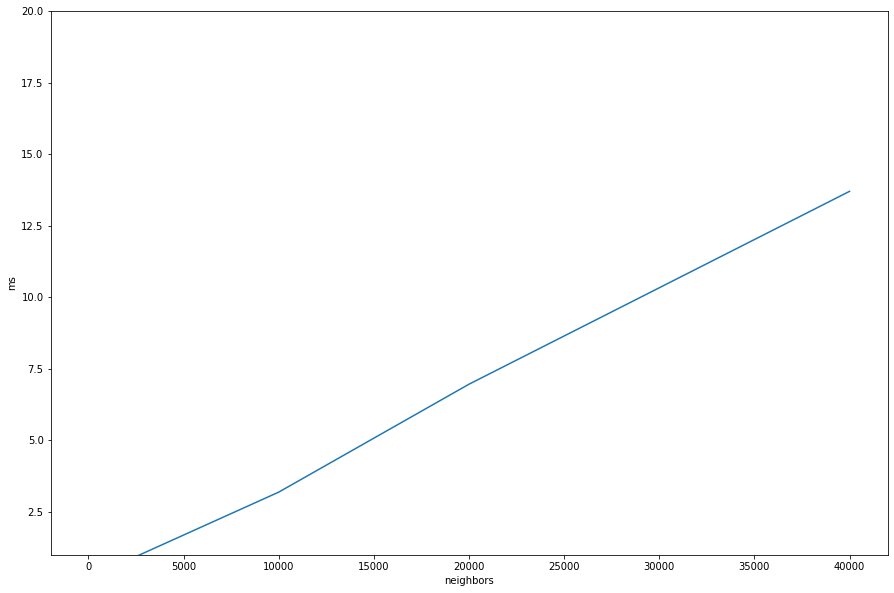

In [58]:
nns = [10, 100, 1000, 10000, 20000, 40000]

# doing the exact same time retrieval as was done in case of
# simple knn

times_improved = []
for k in nns:

    # selecting a random point from teh dataset

    random_point = random.choice(dataset)[0]

    # starting the timer
    # retrieving the nearest neighbors
    # stopping the timer and adding time it to the list

    start = time.time()
    dist, ind = tree.query(np.asarray(random_point).reshape(1,-1), k = k)
    end = time.time()

    times_improved.append((end - start) * 1000)

# plotting the results

plt.figure(figsize=(15, 10))
plt.xlabel('neighbors')
plt.ylabel('ms')
# plt.yscale('log', basey=10)
plt.ylim(1, 20)
plt.plot(nns, times_improved)
plt.show()

What do you observe? Do you see any trends, how can you explain them?

<span style="color:blue"> Your answer: </span> clearly, the **time** needed to maintain nearly the same job **has reduced**, and the graph of retrieval times forms more like a **linear** function. It can be explained as follows: in case of simple knn algorithm went through **all the data** not depending on number of neighbors, but this time the **K-dimensional tree structure** allowed it to visit only **certain** regions depending on how many neighbors it needs to retrieve, and not go thorugh all the data. The **complexity** of such approach maybe be expressed as $O(k \cdot log(N))$ where $log(N)$ is the amount of times it takes to retrieve a neighbor from a KDTree of size $N$, and $k$ is the amount of needed neighbors

### 1.3 Comparison

Plot retrieval times together in the same plot. If time difference is big (as it should be), use a logarithmic scale for better visualization. If you don't achieve any time improvements, then you are doing something wrong.

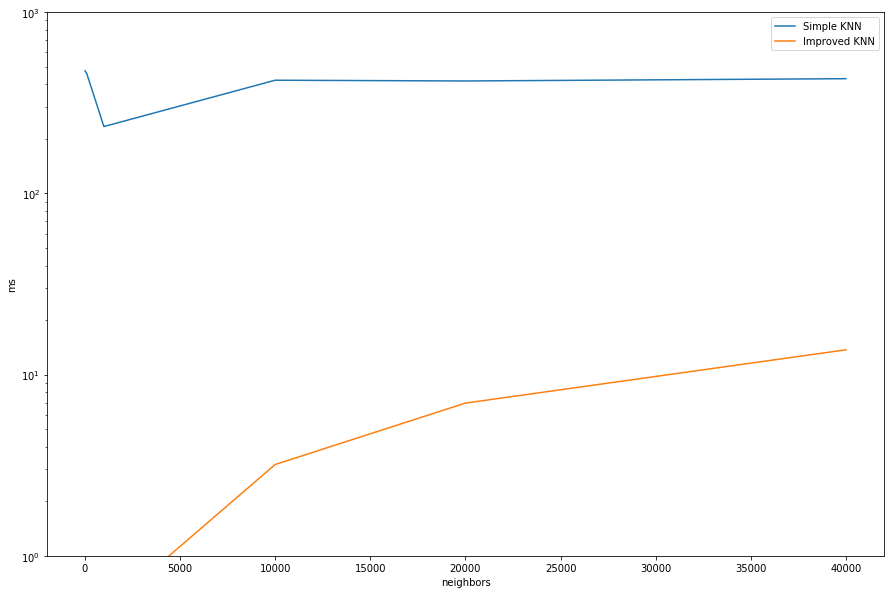

In [61]:
# plotting retrieval times together

plt.figure(figsize=(15, 10))
plt.yscale('log', basey=10)
plt.xlabel('neighbors')
plt.ylabel('ms')
plt.ylim(1, 10**3)
plt.plot(nns, times_simple, label='Simple KNN')
plt.plot(nns, times_improved, label="Improved KNN")
plt.legend()
plt.show()

Analyze the results and summarise them here. 

<span style="color:blue"> Your answer: </span> **simple knn** provides an easy to understand and implement algorithm, but its original version has a very striking drawback - **latency**. Intuitive approach has led to big execution time that **does not** depend on the k parameter. We can confirm that by looking on the graph of retrieval times. However, there was a room for an **improvement**: reorganizing original data in a specific form of **tree** can allow us not to visit all data at once but visit **only closest regions** to a needed point, which can lead to a significantly better performance. That can also be justified by looking on the graph of retrieval times which in case of improved knn forms more of a **linear** function that depends on k parameter while simple approach represents something like a **constant** function which only depends on the dataset size

## 2. Gaussian Naive Bayes (4 points)

Finish the implementation of Gaussian NB.

In [62]:
from math import pi, e, log

# implementing function that represents normal distribution
# with custom mean and standard deviation values

def normal_distribution(x, mean, std):
    return 1 / sqrt(2 * pi * std ** 2) * e ** (- (x - mean) ** 2 / (2 * std ** 2))

class GaussianNB:
    def fit(self, X_train, y_train):
        """
        fit classifier, i.e. calculate needed statistics
        """
        
        # defining dimensions of data
        # NOTE: features and classes variables are made class attributes
        # so they are available in predict function
        
        samples = X_train.shape[0]
        self.features = X_train.shape[1]
        self.classes, classes_counts = np.unique(y_train, return_counts=True)
        
        # calculating the prior probability
        
        self.prior = dict.fromkeys(self.classes)
        for i in range(self.classes.size):
            self.prior[self.classes[i]] = classes_counts[i] / samples
            
        # defining dictionary of features that correspond to every class
            
        cf = dict.fromkeys(self.classes)
        for cls in self.classes: cf[cls] = dict.fromkeys([i for i in range(self.features)])
        for cls in self.classes:
            for i in range(self.features): cf[cls][i] = []

        # filling in the dictionary with data from X_train
        # so later we can calculate mean value and standard deviation
                
        for i in range(samples):
            for j in range(self.features):
                cf[y_train[i]][j].append(X_train[i][j])
                
        # defining structures that will hold mean values
        # and standard deviation values for each class and each features
                
        self.means = dict.fromkeys(self.classes)
        for cls in self.classes: self.means[cls] = dict.fromkeys([i for i in range(self.features)])
        self.std = dict.fromkeys(self.classes)
        for cls in self.classes: self.std[cls] = dict.fromkeys([i for i in range(self.features)])
            
        # going through dictionary of class features and defining mean
        # and standard deviation values
        
        for cls in self.classes:
            for j in range(self.features):
                self.means[cls][j] = np.mean(cf[cls][j])
                self.std[cls][j] = np.std(cf[cls][j])
        
    def predict(self, X_test):
        """
        predict class labels for test data points
        param: test_data: list of data points to be classified
        return: predictions (class labels)
        """
        
        predictions = []
        
        # going through test set one by one
        # and assignmning prediction label to each instance
        # of test set
        
        for x in X_test:
            
            # creating dictionary that will hold all probabilitites
            # that correspond to probabilities of each instacne
            # to be of that class
            
            class_pred = dict.fromkeys(self.classes)
            for cls in self.classes:
                
                # calculating the log of likelyhood 
                
                likelyhood = 0
                for i in range(self.features):
                    likelyhood += log(normal_distribution(x[i], self.means[cls][i], self.std[cls][i]))
                    
                # adding log of likelyhood and log of prior probability
                # to obtain the posterior class probability
                    
                class_pred[cls] = log(self.prior[cls]) + likelyhood
                
            # assign precitiong label of class which has
            # the greatest posterior probability
                
            predictions.append(max(class_pred, key = class_pred.get))
        
        return predictions

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9666666666666667


## 3. PCA

Apply PCA to the Digits dataset, produce the scree plot for the given data and decide the optimal number of PCs to keep. Calculate and print their total explained variance.

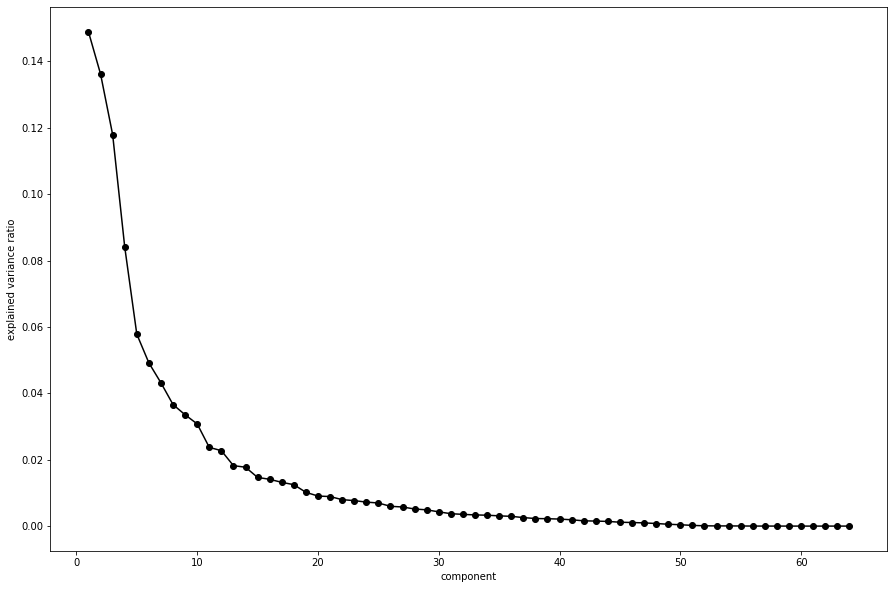

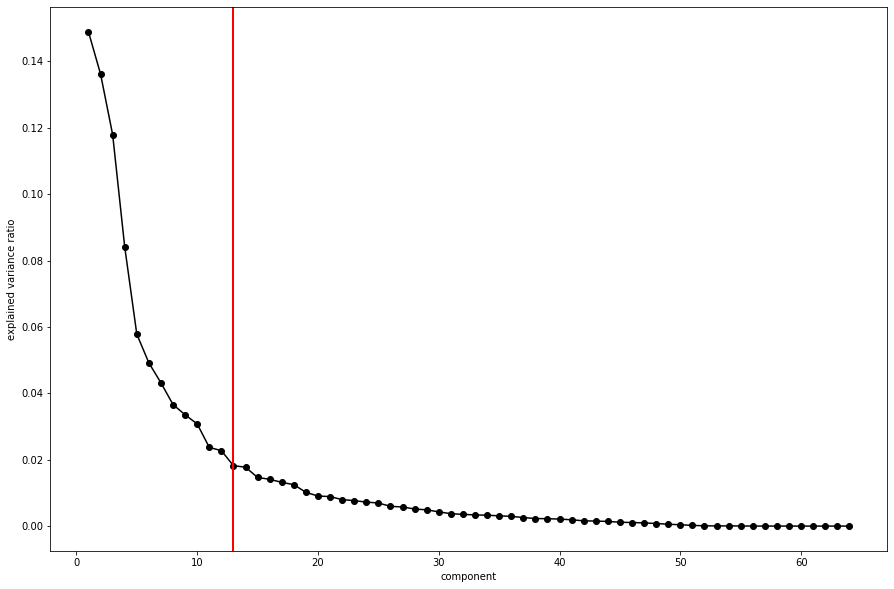

For 13 principal components cumulative explained variance is 0.8028957761040318


In [64]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

# loading the dataset

X, y = load_digits(return_X_y=True)

# applying PCA

pca = PCA(n_components = X.shape[1])
X_pca = pca.fit_transform(X)

# making the scree plot out of explained variance proportion
# to visualize the impact of individual component to the overall
# amount of variance

plt.figure(figsize=(15, 10))
plt.plot(range(1, X.shape[1] + 1), pca.explained_variance_ratio_,
         linestyle='-', marker='o', color='black')
plt.xlabel("component")
plt.ylabel("explained variance ratio")
plt.show()

# choosing the number PCs according to their cumulative explained variance
# and selected threshold

threshold = 0.8
cum_var = 0
k = 0

while cum_var < threshold:
    cum_var += pca.explained_variance_ratio_[k]
    k += 1
    
# at this point only first k principal components result in the cumulative explained variance
# that is equal to the selected threshold
# below is the plot that illustrates the choice

plt.figure(figsize=(15, 10))
plt.plot(range(1, X.shape[1] + 1), pca.explained_variance_ratio_,
         linestyle='-', marker='o', color='black')
plt.axvline(x = k, linewidth=2, color='r')
plt.xlabel("component")
plt.ylabel("explained variance ratio")
plt.show()

print("For {} principal components cumulative explained variance is {}".format(k, cum_var))

Thoroughly justify your choice - this is the main part of the work for this task.

<span style="color:blue"> Your answer: </span> I selected the number of principal components according to **threshold** of their **cumulative explained variance**. It is important to note, that this particular thhreshold value can **differ** from task to task, depending on how much variance we are ready to let go in order to reduce the dimensions of the data: in this particular task we may assume that **80%** of initial variance would be enough to maintain the data structure. Also, it is clear from the **graph** that after certain principal component next ones **do not** contribute much to overall variance. Although, the choice of threshold very much depends on the **essence of the task and data** itself: if the task, for example, was to reduce some **small noise** in the data, the choice would be slightly different (90-95%); also, if the task would be to **reduce compelxity** and dimensions of the initial data, the choice would be in around 70-80% meaning that we may allow to sacrifice 20-30% of variance to achieve our goal